In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools


In [2]:
df = pd.read_csv('dataset.csv')
df.drop(columns=['Time', 'location', 'File Name', 'Propagation Delay (s)', 'E2E Delay (s)'], inplace=True)
df.head()

,model,processing_delay (ms),core,model_acc,ram
0,yolov5m,2725.300789,half,64.1,1000
1,yolov5m,2869.115829,half,64.1,1000
2,yolov5m,2394.518852,half,64.1,1000
3,yolov5m,2873.452187,half,64.1,1000
4,yolov5m,2371.568680,half,64.1,1000


In [3]:
df['model_acc'].unique()

array([64.1, 45.7, 56.8])

In [4]:
latency_bound = 700  # in ms
sla_violations = df[df['processing_delay (ms)'] > latency_bound]

# Count SLA violations for each core
sla_violation_counts = sla_violations.groupby(['model','core']).size().reset_index(name='violation_count')
sla_violation_counts['per_core_violations'] = (sla_violation_counts['violation_count']/1000)*100
# Generate all possible combinations of model and core
models = df['model'].unique()
cores = df['core'].unique()

all_combinations = pd.DataFrame(list(itertools.product(models, cores)), columns=['model', 'core'])

# Merge with sla_violation_counts to ensure all combinations are included
complete_sla_violation_counts = all_combinations.merge(sla_violation_counts, on=['model', 'core'], how='left')
# Fill missing values with zero
complete_sla_violation_counts['violation_count'] = complete_sla_violation_counts['violation_count'].fillna(0)
complete_sla_violation_counts['per_core_violations'] = complete_sla_violation_counts['per_core_violations'].fillna(0)
sla_violate =  complete_sla_violation_counts


In [5]:
sla_violate.sort_values(by=['core'])

,model,core,violation_count,per_core_violations
0,yolov5m,half,1000.0,100.0
3,yolov5n,half,367.0,36.7
6,yolov5s,half,1000.0,100.0
1,yolov5m,one,1000.0,100.0
4,yolov5n,one,1.0,0.1
7,yolov5s,one,327.0,32.7
2,yolov5m,two,514.0,51.4
5,yolov5n,two,0.0,0.0
8,yolov5s,two,0.0,0.0


In [6]:
sla_violate.sort_values(by=['core', 'model'])

,model,core,violation_count,per_core_violations
0,yolov5m,half,1000.0,100.0
3,yolov5n,half,367.0,36.7
6,yolov5s,half,1000.0,100.0
1,yolov5m,one,1000.0,100.0
4,yolov5n,one,1.0,0.1
7,yolov5s,one,327.0,32.7
2,yolov5m,two,514.0,51.4
5,yolov5n,two,0.0,0.0
8,yolov5s,two,0.0,0.0


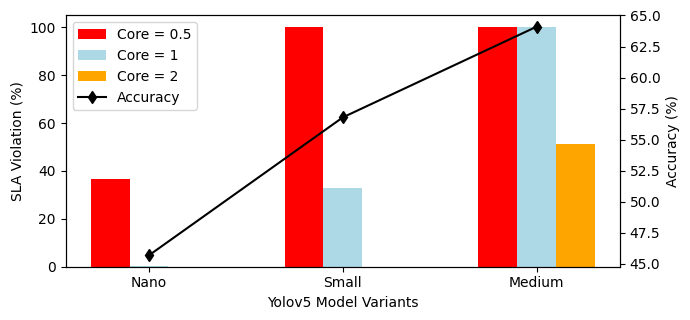

In [7]:
# Data
models = ['Nano', 'Small', 'Medium']
sla_half = [36.7, 100.0, 100.0]
sla_one = [0.1, 32.7, 100.0]
sla_two = [0.0, 0.0, 51.4]
accuracy = [45.7, 56.8, 64.1]

# Create figure and axis objects
fig, ax1 = plt.subplots(1, 1, figsize=(7,3.3))

# Plot throughput on the first y-axis
ax1.set_xlabel('Yolov5 Model Variants')
ax1.set_ylabel('SLA Violation (%)')
bar_width = 0.2
x = np.arange(len(models))
ax1.bar(x - bar_width, sla_half, bar_width, label='Core = 0.5', color='red')
ax1.bar(x, sla_one, bar_width, label='Core = 1', color='lightblue')
ax1.bar(x + bar_width, sla_two, bar_width, label='Core = 2', color='orange')
ax1.legend(loc='upper left')

# Create the second y-axis
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy (%)')
line, = ax2.plot(x, accuracy, marker='d', color='black', label='Accuracy')

# Combine legends
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + [line], labels1 + labels2, loc='upper left')

fig.tight_layout()
# Set x-axis labels
ax1.set_xticks(x)
ax1.set_xticklabels(models)
plt.savefig('motivation_sla_800.pdf', format='pdf')
plt.show()


# Model Switching

In [8]:
dfms = pd.read_csv('model_switching.csv')
model_accuracies = {
    'yolov5n': 0.457,
    'yolov5s': 0.568,
    'yolov5m': 0.641
}

In [9]:
dfms.drop(columns=['time', 'location', 'file_name', 'propagation_delay (s)', 'e2e_delay (s)'], inplace=True)

In [10]:
dfms['core'].unique()

array([ 500, 1000, 2000])

In [11]:
dfms1 = dfms[dfms['cid']==1]
dfms1['model_name'].unique()

array(['yolov5s', 'yolov5m'], dtype=object)

In [12]:
sla_violations = dfms[dfms['processing_delay (ms)'] > 700].groupby('core').size()
sla_violations

core
500     57
1000    51
2000     7
dtype: int64

In [13]:
total_traffic = dfms.groupby('core').size()
sla_violation_rate = (sla_violations / total_traffic) * 100
sla_violation_rate

core
500     56.435644
1000    50.495050
2000     6.930693
dtype: float64

In [14]:
dfms

,cid,model_name,processing_delay (ms),core
0,0,yolov5n,846.629620,500
1,1,yolov5s,662.415028,1000
2,2,yolov5m,552.519083,2000
3,0,yolov5n,1033.409357,500
4,1,yolov5s,727.887869,1000
...,...,...,...,...
298,1,yolov5m,1285.557747,1000
299,2,yolov5m,693.729639,2000
300,0,yolov5n,542.279243,500
301,1,yolov5m,1071.745872,1000


In [15]:
# Calculate the average accuracy for each core
dfms['model_accuracy'] = dfms['model_name'].map(model_accuracies)
traffic_by_core_model = dfms.groupby(['core', 'model_name']).size().unstack(fill_value=0)
average_accuracies = {}
for core in traffic_by_core_model.index:
    total_traffic_core = total_traffic[core]
    weighted_sum = 0
    for model in traffic_by_core_model.columns:
        traffic_by_model = traffic_by_core_model.loc[core, model]
        if traffic_by_model > 0:
            model_accuracy = model_accuracies[model]
            weighted_sum += (traffic_by_model / total_traffic_core) * model_accuracy
    average_accuracies[core] = weighted_sum * 100  # Convert to percentage



In [16]:
traffic_by_core_model

model_name,yolov5m,yolov5n,yolov5s
core,,,
500,0,101,0
1000,49,0,52
2000,101,0,0


In [17]:
# Prepare data for plotting
cores = list(sla_violation_rate.index)
sla_rates = list(sla_violation_rate.values)
accuracies = [average_accuracies[core] for core in cores]

In [18]:
accuracies

[45.7, 60.34158415841584, 64.1]

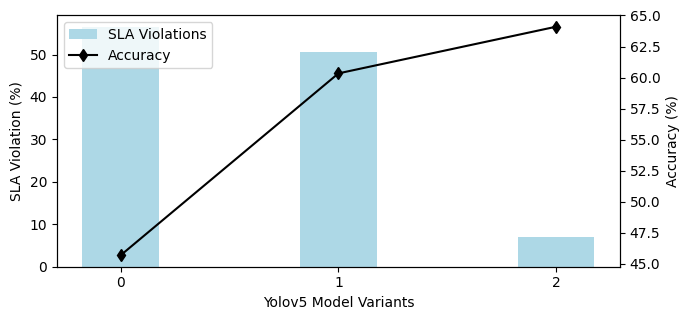

In [19]:
# Data
cores = [500, 1000, 2000]
sla_rates = [56.435, 50.495, 6.930]
accuracies = [45.7, 60.34158415841584, 64.1]

fig, ax1 = plt.subplots(1, 1, figsize=(7,3.3))

bar_width = 0.35
x1 = np.arange(len(cores))
x2 = [x + bar_width for x in x1]

ax1.bar(x1, sla_rates, width=bar_width, label='SLA Violations', color='lightblue')

ax1.set_xlabel('Yolov5 Model Variants')
ax1.set_ylabel('SLA Violation (%)')
ax1.legend(loc='upper left')

# Create the second y-axis
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy (%)')
line, = ax2.plot(x, accuracies, marker='d', color='black', label='Accuracy')

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + [line], labels1 + labels2, loc='upper left')

fig.tight_layout()

ax1.set_xticks(x)
#plt.savefig('motivation_sla_800.pdf', format='pdf')
plt.show()

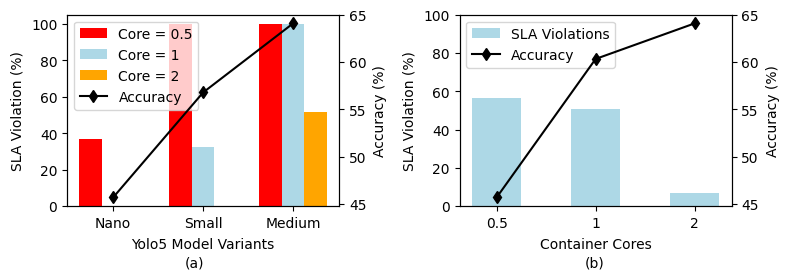

In [55]:
# Data for figure 1
cores = [500, 1000, 2000]
sla_rates = [56.435, 50.495, 6.930]
accuracies = [45.7, 60.34158415841584, 64.1]

# Data for figure 2
models = ['Nano', 'Small', 'Medium']
sla_half = [36.7, 100.0, 100.0]
sla_one = [0.1, 32.7, 100.0]
sla_two = [0.0, 0.0, 51.4]
accuracy = [45.7, 56.8, 64.1]

# Create figure and axis objects for subplots
fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(8,2.8))

# Plot figure 1
bar_width = 0.5
x3 = np.arange(len(cores))

ax3.bar(x3, sla_rates, width=bar_width, label='SLA Violations', color='lightblue')
ax3.set_xlabel('Container Cores', labelpad=5)
ax3.set_ylabel('SLA Violation (%)', labelpad=5)
ax3.set_ylim([0,100])
ax3.legend(loc='upper left')

# Create the second y-axis for figure 1
ax4 = ax3.twinx()
ax4.set_ylabel('Accuracy (%)', labelpad=5)
line1, = ax4.plot(x3, accuracies, marker='d', color='black', label='Accuracy')

handles1, labels1 = ax3.get_legend_handles_labels()
handles2, labels2 = ax4.get_legend_handles_labels()
ax3.legend(handles1 + [line1], labels1 + labels2, loc='upper left')

ax3.set_xticks(x3)
ax3.set_xticklabels(['0.5', '1', '2'])

# Plot figure 2
bar_width = 0.25
x1 = np.arange(len(models))
ax1.bar(x1 - bar_width, sla_half, bar_width, label='Core = 0.5', color='red')
ax1.bar(x1, sla_one, bar_width, label='Core = 1', color='lightblue')
ax1.bar(x1 + bar_width, sla_two, bar_width, label='Core = 2', color='orange')
ax1.set_xlabel('Yolo5 Model Variants', labelpad=5)
ax1.set_ylabel('SLA Violation (%)', labelpad=5)
#ax1.set_ylim([0,100])
ax1.legend(loc='upper left')

# Create the second y-axis for figure 2
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy (%)', labelpad=5)
line2, = ax2.plot(x1, accuracy, marker='d', color='black', label='Accuracy')

handles3, labels3 = ax1.get_legend_handles_labels()
handles4, labels4 = ax2.get_legend_handles_labels()
ax1.legend(handles3 + [line2], labels3 + labels4, loc='upper left')

ax1.set_xticks(x1)
ax1.set_xticklabels(models)

# Add subplot labels
fig.text(0.25, 0.04, '(a)', ha='center', va='center', fontsize=10)
fig.text(0.75, 0.04, '(b)', ha='center', va='center', fontsize=10)

fig.subplots_adjust(wspace=0.2, bottom=0.25)  # Increased bottom margin significantly
fig.tight_layout(rect=[0, 0.03, 1, 1])
plt.savefig('motivation_sla_combined.pdf', format='pdf')
plt.show()

/tmp/ipykernel_15360/967422714.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(cores)


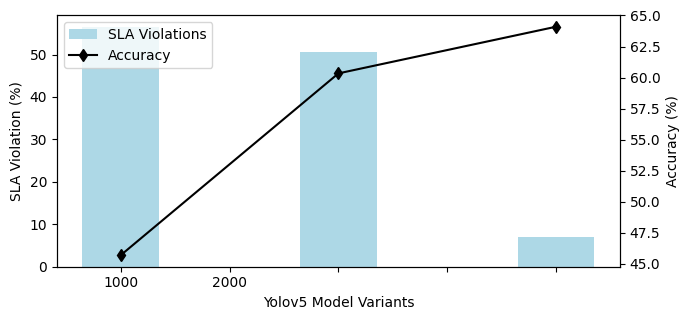

In [70]:
# Data
cores = [500, 1000, 2000]
sla_rates = [56.435, 50.495, 6.930]
core_model0 = np.array([101, 0, 0])
core_model1 = np.array([0, 52, 49])
core_model2 = np.array([0, 0, 101])

# Create figure and axis objects
fig, ax1 = plt.subplots(1, 1, figsize=(7,3.3))

bar_width = 0.35
x1 = np.arange(len(cores))
x2 = [x + bar_width for x in x1]

ax1.bar(x1, sla_rates, width=bar_width, label='SLA Violations', color='lightblue')

# Plotting the stacked bar graph
#ax1.bar(x2, core_model0, color='r', width=bar_width, label='Nano')
#ax1.bar(x2, core_model1, color='lightblue', bottom=core_model0, width=bar_width, label='Small')
#ax1.bar(x2, core_model2, color='orange', bottom=core_model0+core_model1, width=bar_width, label='Medium')

#ax1.set_xticks([r + bar_width/2 for r in range(len(cores))])
#ax1.set_xticklabels(cores)
ax1.set_xlabel('Yolov5 Model Variants')
ax1.set_ylabel('SLA Violation (%)')
ax1.legend(loc='upper left')

# Create the second y-axis
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy (%)')
line, = ax2.plot(x, accuracies, marker='d', color='black', label='Accuracy')

# Combine legends
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + [line], labels1 + labels2, loc='upper left')

fig.tight_layout()
# Set x-axis labels
#ax1.set_xticks(x)
ax1.set_xticklabels(cores)
#plt.savefig('motivation_sla_800.pdf', format='pdf')
plt.show()

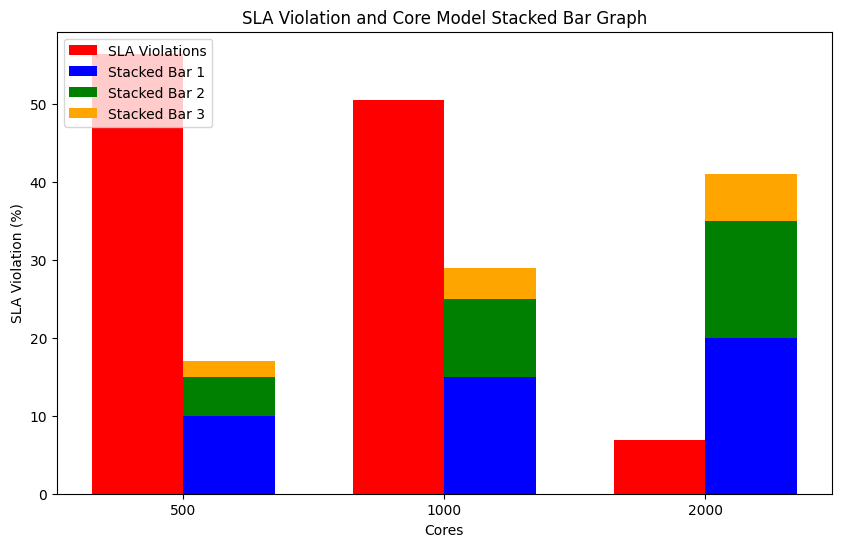

In [58]:
cores = [500, 1000, 2000]
sla_rates = [56.43564356435643, 50.495049504950494, 6.93]
core_model0 = np.array([10, 15, 20])
core_model1 = np.array([5, 10, 15])
core_model2 = np.array([2, 4, 6])

# Parameters for bar width and positions
bar_width = 0.35
x1 = np.arange(len(cores))
x2 = x1 + bar_width

# Create subplots
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting the straight bar graph
ax1.bar(x1, sla_rates, width=bar_width, label='SLA Violations', color='red')

# Plotting the stacked bar graph
ax1.bar(x2, core_model0, color='blue', width=bar_width, label='Stacked Bar 1')
ax1.bar(x2, core_model1, bottom=core_model0, color='green', width=bar_width, label='Stacked Bar 2')
ax1.bar(x2, core_model2, bottom=core_model0 + core_model1, color='orange', width=bar_width, label='Stacked Bar 3')

# Setting x-ticks, labels, and legend
ax1.set_xticks(x1 + bar_width / 2)
ax1.set_xticklabels(cores)
ax1.set_xlabel('Cores')
ax1.set_ylabel('SLA Violation (%)')
ax1.legend(loc='upper left')

# Display the plot
plt.title('SLA Violation and Core Model Stacked Bar Graph')
plt.show()

In [18]:
cores

[500, 1000, 2000]

In [142]:
model_counts = dfms.groupby(['cid', 'model_name']).size().unstack(fill_value=0)
model_counts

model_name,yolov5m,yolov5n,yolov5s
cid,,,
0,0,101,0
1,49,0,52
2,101,0,0


In [143]:
dfms['core'].unique()

array([ 500, 1000, 2000])

In [144]:
# Count the number of occurrences for each core
core_counts = dfms.groupby('cid').size()

# Calculate the number of SLA violations for each cid
sla_violations = dfms[dfms['processing_delay (ms)'] > 800].groupby('cid').size()
(sla_violations/ core_counts)*100

cid
0    53.465347
1    48.514851
2     1.980198
dtype: float64

In [145]:
core_counts = dfms.groupby('core').size()

# Calculate the number of SLA violations for each cid
sla_violations = dfms[dfms['processing_delay (ms)'] > 800].groupby('core').size()
(sla_violations/ core_counts)*100

core
500     53.465347
1000    48.514851
2000     1.980198
dtype: float64

In [146]:


# Calculate the traffic handled by each model for each cid
traffic_handled = dfms.groupby(['core', 'model_name']).size().unstack(fill_value=0)

# Calculate the total traffic for each cid
total_traffic = dfms.groupby('cid').size()

# Calculate the weighted average accuracy for each cid
average_accuracies = {}


In [147]:
traffic_handled

model_name,yolov5m,yolov5n,yolov5s
core,,,
500,0,101,0
1000,49,0,52
2000,101,0,0


In [148]:
traffic_handled.index

Index([500, 1000, 2000], dtype='int64', name='core')

In [149]:
for cid in traffic_handled.index:
    total_traffic_cid = total_traffic[cid]
    weighted_sum = 0
    for model in traffic_handled.columns:
        traffic_by_model = traffic_handled.loc[cid, model]
        if traffic_by_model > 0:
            model_accuracy = model_accuracies[model]
            weighted_sum += (traffic_by_model / total_traffic_cid) * model_accuracy
    average_accuracies[cid] = weighted_sum

print("Average accuracies for each cid:")
print(average_accuracies)

KeyError: 500